### Using Python BeautifulSoup to scrape Data Camp Tutorials & Analyze

In this tutorial, Why not scrape the tutorials section of the data camp website itself and try to get some insights including but not limited to the following! 

* Most contributing authors
* Timeline of contributors (How it all started!)
* Comparing upvotes vs number of articles published

But before that, the website will be scraped using python's BeautifulSoup package

In order to understand the page structure, Chrome browser developer tools will be used. This is done to identify the Classes that will be searched for the get the required information.

Following information will be gathered from the page

* Author
* Publish Date
* Title
* Desription
* Up Votes



### Importing Libraries

We'll start by importing necessary libraries as follows

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup


### Determining Pages to be Scraped

A sampe URL that we're going to loop and scrape is the following https://www.datacamp.com/community/tutorials?page=2 . As we can see, the page=2 argument changes for each page.
In order to loop through all the pages to get the necessary dataset, we need to find out the number of pages.

The following lines of code do just that


In [2]:
url = "https://www.datacamp.com/community/tutorials"
html = urlopen(url)
soup = BeautifulSoup(html, 'html')

pages = [i.text for i in soup.find_all('a') if 'community/tutorials?page=' in str(i)]
lastpage = pages[-1]

In [3]:
print(lastpage)

12


Illustration is as follows

* Specified the url to a variable
* Opened the url using urlopen which was imported earlier
* Scraped the specified page and assigned it to soup variable
* Identified all hyperlinks on the page using list comprehension and filtered for those haivng community/tutorials?page= in it
* The text value of the last found url has the last page that needs to be scraped

We proceed by declaring list variables that will hold the scraped values for the columns we intent as mentioned earlier 

In [14]:
description=[]
upvote=[]
author=[]
publishdate=[]
title=[]

### Doing the Actual Scrape

Now that we know how many pages we need to scrape and declared our variables, we will now use a for loop and go through each page one by one to get our fields of interest as shown below. Note that we will end up having list of lists for each column of interest but later we will be flattening the list further so that it can be used for Data Frames.

In [15]:
for cp in np.arange(1,int(lastpage)+1):
    url = "https://www.datacamp.com/community/tutorials?page=" + str(cp)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html')
    description.append([i.text for i in soup.find_all(class_='jsx-379356511 blocText description')])
    upvote.append([i.text for i in soup.find_all(class_='jsx-4192737526 voted')])
    author.append([i.text for i in soup.find_all(class_='jsx-566588255 name')])
    publishdate.append([i.text for i in soup.find_all(class_='jsx-566588255 date')])
    title.append([i.text for i in soup.find_all(class_='jsx-379356511 blue')])
    time.sleep(3)
print ("Done!")

Done!


Here is what happened in the above code segment

* Set the url to a variable
* Opened the url using urlopen which was imported earlier
* Scraped the specified page and assigned it to soup variable
* Identified and extracted values for Description, Up Vote, Author, Publish Date, Title by using their relevant class names. These class names were found using Developer Tools
* The time function has been used to be easy on the website this time :)



### Flattening List of Lists

Since the values we got are list of lists, they will now be flatted using the following code segment

In [18]:
descriptionflat = [y for x in description for y in x]
upvoteflat = [y for x in upvote for y in x]
authorflat = [y for x in author for y in x]
publishdateflat = [y for x in publishdate for y in x]
titleflat = [y for x in title for y in x]
publishdateformatted = [datetime.strptime(re.sub('rd, ', ', ', re.sub('st, ', ', ', re.sub('nd, ', ', ', re.sub('th, ',', ',a)))), "%B %d, %Y") for a in publishdateflat]

The last statement in the cell above converts the date values (which are currently in String Format) to DateTime.

### Making a Data Frame and Saving as CSV File

The lists will now be grouped into a dictionary and a data frame will be created for further analysis.
The last command saves the data frame to a csv file so that it can be used later on.

In [21]:
cdata = {"author":authorflat,"publishdate":publishdateformatted,"title":titleflat,"description":descriptionflat,"upvote":upvoteflat}
df = pd.DataFrame(data = cdata)
df.to_csv("c:\\users\\ssalahuddin\\documents\\datacamp130818.csv", header=True, index=False)


### Reading CSV File

Now we are attempting to read in the collected dataset from the csv file we just created

In [27]:
datacamp = pd.read_csv("c:\\users\\ssalahuddin\\documents\\datacamp130818.csv", parse_dates=["publishdate"], infer_datetime_format=True)

In [29]:
datacamp.shape

(176, 5)

Above command tells us we're dealing with a dataset of 176 rows and 5 columns

In [95]:
datacamp.head()

,author,description,publishdate,title,upvote,publishyymm
0,Rohit Peesa,This tutorial that will demonstrate how you ca...,2018-08-13,Datasets From Images,3,2018-Aug
1,Luke Hayden,"In this tutorial, you'll learn how to use PCA ...",2018-08-09,Principal Component Analysis in R,14,2018-Aug
2,Sejal Jaiswal,"In this tutorial, you will learn exclusively a...",2018-08-08,"Python IF, ELIF, and ELSE Statements",3,2018-Aug
3,Duong Vu,Learn how to perform Exploratory Data Analysis...,2018-08-07,Generating WordClouds in Python,14,2018-Aug
4,Keith Singleton,"In this tutorial, you’ll learn how to pull dat...",2018-08-07,MeetUp API– Pulling Data & Writing it into a JSON,4,2018-Aug


Showing the first 5 rows of the dataset above using the head function

In [186]:
datacamp['publishyymm'] = datacamp['publishdate'].dt.strftime("%Y-%b")
datacamp["posts"] = 1

* The first line in the above code section creates a new column with publish date formated as Year-Month format.
* Second line assigns value 1 to a new column posts being used later 

### Tutorials Count by Time

Here we will organize the count of Tutorials over Timeline of Year and Month

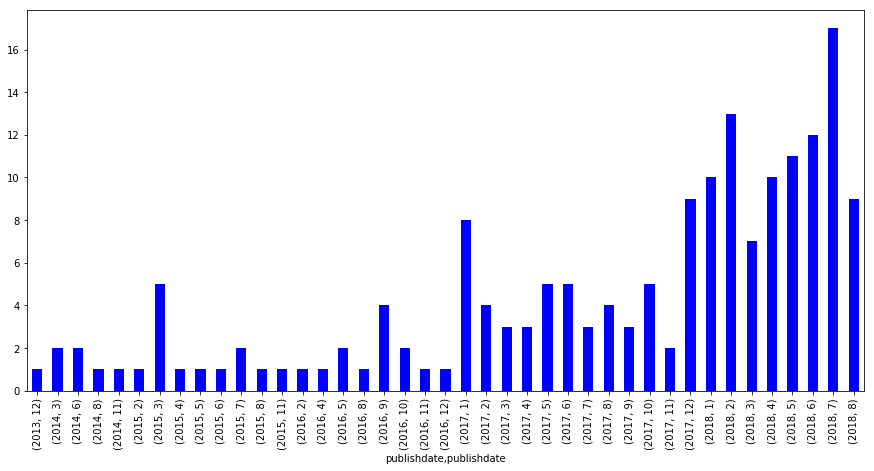

In [287]:

datacamp.groupby([datacamp['publishdate'].dt.year, datacamp['publishdate'].dt.month]).size().plot(kind='bar', figsize=(15,7), color='b')


### Since 2017 January

Since the duration from 2013 till 2016 represent very few posts, we will be ignoring them from now and considering posts starting Jan 2017. A filter will be applied for that as shown below

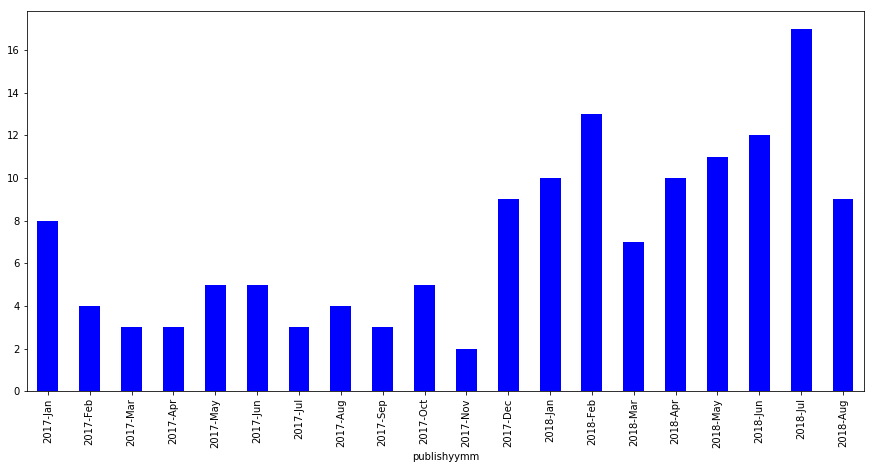

In [288]:
datacamp[datacamp["publishdate"]>='2017-01-01'].sort_values(by="publishdate", ascending=True).groupby([datacamp['publishyymm']],sort=False).size().plot(kind='bar', figsize=(15,7), color='b')

Tutorials have paced up in 2018 with especially starting March onwards with a consistent upwards pace. Since we are in mid August and already almost crossing the middle line of July's tutorials count, we might be having July as the month with highest posts so far this year!

### Top Authors Graph

While we're pacing up on all these tutorials, who have been contributing on them along the way? 
Here we go with a simple bar chart highlighting this very fact.

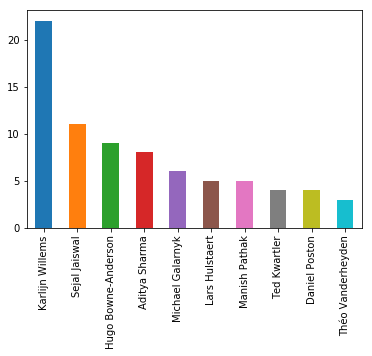

In [297]:
datacamp[datacamp["publishdate"]>='2017-01-01']["author"].value_counts(sort=True, ascending=False)[:10].plot(kind='bar')

### Top Authors List

Let's build a list of these as well while we are at it. Will be using this soon below

In [298]:
topauthors = datacamp[datacamp["publishdate"]>='2017-01-01']["author"].value_counts(sort=True, ascending=False)[:10].index

This is what happened in the code section above

* Limited Result set to Tutorials since 2017 January
* Select only Author field
* Aggregated results using value_counts function
* Sorted result set in descending order and limiting it to first 10 rows

### Tutorials Paced over Timeline

Now what we're going to focus on is since when and at what pace have these top 10 contributors been posting tutorials. For this, we will be using the list we just created along with some transformations to come up with a stacked bar chart that we need.

In [201]:
dh = datacamp[datacamp["publishdate"]>='2017-01-01'].sort_values(by="publishdate", ascending=True).set_index(["publishdate"])
dh["publishdateone"] = pd.to_datetime(dh.publishdate.astype(str).str[0:7]+'-01')

This is what happened in the code section above

* Limited Result set to Tutorials since 2017 January
* Sorted by Publish Date
* Making Publish Date as the Index column

Now that we're going to visualize using a stacked bar char, the data set will now be pivoted by having the date field as Index, Posts as values which are to be aggregated and Authors as columns

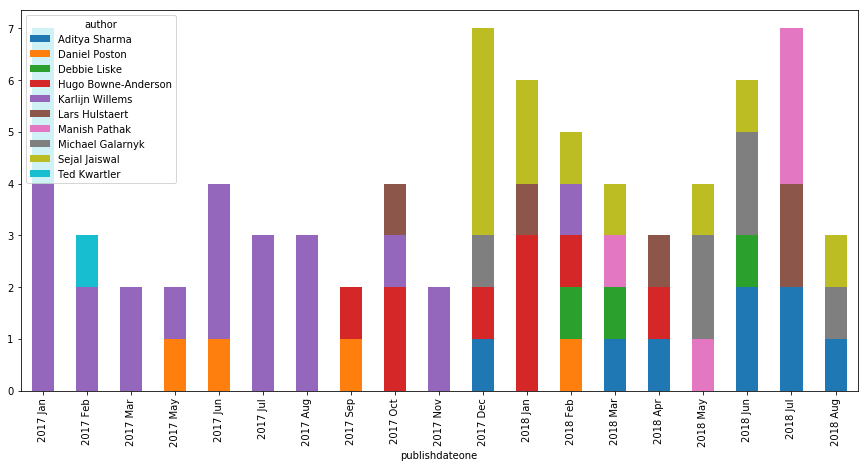

In [275]:
dhp = dh[dh["author"].isin(topauthors)].pivot_table(index="publishdateone",values="posts",columns="author", aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(15,7))
dhp.plot(ax=ax, kind='bar', stacked=True)
ticklabels = [item.strftime('%Y %b') for item in dhp.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))


Here is what we possibly get out of the above Chart along with considering the earlier visualization of Tutorial Counts by Authors

* While Karlijn Willems has been at the top for Tutorials count, She's also the first to start it all off! But seem to be slowing down :)
* Sejal Jaiswal while being the third by count, start high pace and is being consistent with an average of 1 post a month
* Aditya Sharma might be crossing Sejal if the same pace is maintained in the coming time.


### Looking at Upvotes vs Tutorials 

When a tutorial is liked by a reader, an upvote is signalled respectively.

Let's see who's managed to get good amount of upvotes vs number of tutorials they have posted!
We'll be considering top 10 contributors in this case as well.
This will be done by using a scatter plot


In [294]:
upvotes = dh[dh["author"].isin(topauthors)].groupby(['author'], as_index=False).agg({'posts':"sum",      
                                     'upvote': "sum"})

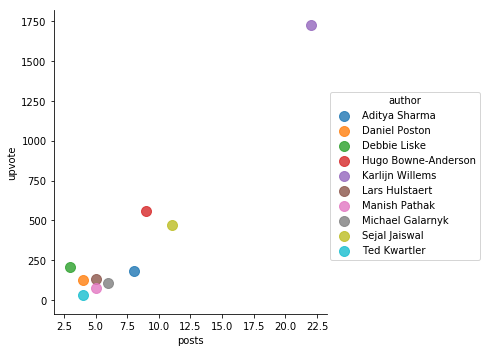

In [295]:
sns.lmplot('posts', 
           'upvote', 
           data=upvotes,
           fit_reg=False, 
           hue="author", 
           scatter_kws={"marker": "D", 
                        "s": 100}) 

While Karlijn Willems has almost double the number of send most posting author, the number of upvotes are way way high! Around 3 times as much compared to Hugo's upvote count. Sejal has managed to be third while others have got some reviews to be made to pace up :)

### Conclusion

In this tutorial, we have managed to achieve the following

* Scrape tutorials list across all pages
* Create a Data Frame and save it as CSV for later reference and Analysis
* Explored it using Pandas and Matplotlib along with some transformations 
* Used Line, Bar, Stacked Bar and Scatter Plots to visualize

I hope this gives a head start to many of us in exploring this and more of data sets in a similar fashion!
